# Word Sense Disambiguation of Word-in-Context data
### Lorenzo Nicoletti - 1797464

## Preliminaries

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Data Acquisition

In [ ]:
# downloading WiC data and restyling my directory on colab
! rm -rf sample_data
! git clone https://github.com/SapienzaNLP/nlp2021-hw3
! mkdir wic_data
! mv nlp2021-hw3/data/train.jsonl wic_data/.
! mv nlp2021-hw3/data/dev.jsonl wic_data/.
! mv nlp2021-hw3/data/dev_wsd.txt wic_data/.
! rm -rf nlp2021-hw3

# downloading training data and benchmarks

# for when the sapienza nlp webpage is unavailable
! cp "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/WSD_Evaluation_Framework.zip" /content/
#! wget http://lcl.uniroma1.it/wsdeval/data/WSD_Evaluation_Framework.zip
! unzip -q WSD_Evaluation_Framework.zip
! mkdir wsd_data
! mv WSD_Evaluation_Framework/Training_Corpora wsd_data
! mv WSD_Evaluation_Framework/Evaluation_Datasets wsd_data
! rm -rf WSD_Evaluation_Framework*

Cloning into 'nlp2021-hw3'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 64 (delta 23), reused 25 (delta 3), pack-reused 0
Unpacking objects: 100% (64/64), done.


### Libraries installation and import

In [ ]:
! pip install transformers
! pip install pytorch-lightning
! pip install jsonlines

     |████████████████████████████████| 2.5MB 9.3MB/s 
     |████████████████████████████████| 3.3MB 50.4MB/s 
     |████████████████████████████████| 901kB 44.8MB/s 
     |████████████████████████████████| 819kB 6.8MB/s 
     |████████████████████████████████| 235kB 22.2MB/s 
     |████████████████████████████████| 122kB 19.8MB/s 
     |████████████████████████████████| 829kB 23.3MB/s 
     |████████████████████████████████| 645kB 32.4MB/s 
     |████████████████████████████████| 10.6MB 33.4MB/s 
     |████████████████████████████████| 1.3MB 40.6MB/s 
     |████████████████████████████████| 143kB 55.7MB/s 
     |████████████████████████████████| 296kB 39.6MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=bdba6030db1a9f930c21c4ac30574fcbaae6d8da784e0d6ab5a8738803ab8fd6
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement ten

In [ ]:
import numpy as np
import torch
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, AdamW
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import re
from typing import Optional, List, Dict, Union, Tuple
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
import csv
from tabulate import tabulate
import jsonlines
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# to guarantee repetability of the experiments if needed
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# device on which we will store everything
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Experiments will run on', DEVICE)

# to map to wordnet pos tags
WORDNET_POS = {'VERB': wordnet.VERB,
               'NOUN': wordnet.NOUN,
               'ADJ': wordnet.ADJ,
               'ADV': wordnet.ADV}

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Experiments will run on cuda


### Experimental setup

Please, use the menu on the right to select the desired configuration of the model and of the datasets to be considered.

In [ ]:
#@title WSD parameters { run: "auto" }

#@markdown Set the desired configuration:
model_name =  "bert-base-uncased"#@param ["bert-base-uncased", "bert-large-uncased", "bert-large-uncased-whole-word-masking"]
model_hidden_size =  768#@param {type:"number"}
model_dropout = 0.1 #@param {type:"slider", min:0, max:1, step:0.1}

do_train = "False" #@param ["True", "False"]
pre_training = "freezed" #@param ["finetuned", "freezed"]
train_dataset = "SemCor" #@param ["SemCor"]
val_dataset = "semeval2007" #@param ["semeval2007", "semeval2013", "semeval2015", "senseval2", "senseval3", "ALL"]
test_dataset = "ALL" #@param ["semeval2007", "semeval2013", "semeval2015", "senseval2", "senseval3", "ALL"]
batch_size =  4#@param {type:"number"}

train_path = 'wsd_data/Training_Corpora/'
val_path = 'wsd_data/Evaluation_Datasets/'

class WSDParams():
  model_name = model_name
  model_dropout = model_dropout
  model_hidden_size = model_hidden_size
  do_train = do_train
  pre_training = pre_training
  train_data_path = train_path + train_dataset + '/' + train_dataset.lower() + '.data.xml'
  train_key_path = train_path + train_dataset + '/' + train_dataset.lower() + '.gold.key.txt'
  val_data_path = val_path + val_dataset + '/' + val_dataset + '.data.xml'
  val_key_path = val_path + val_dataset + '/' + val_dataset + '.gold.key.txt'
  test_data_path = val_path + test_dataset + '/' + test_dataset + '.data.xml'
  test_key_path = val_path + test_dataset + '/' + test_dataset + '.gold.key.txt'
  batch_size = batch_size
  
wsd_params = WSDParams()

Once defined the `BertTokenizer` that we will use for the tokens encoding, we need to add the special token, **[TGT]**, to be inserted between the ambiguos word to be disambiguated in the sentence.

Otherwise, the tokenizer will not be able to recognize it.

In [ ]:
# defining a 'global' tokenizer to have it always available
tokenizer = BertTokenizer.from_pretrained(wsd_params.model_name,
                                          do_lower_case=True)

print(len(tokenizer))
tokenizer.add_special_tokens({'additional_special_tokens': ['[TGT]']})
print(len(tokenizer))


30522
30523


## Data Preprocessing and WSDDataset

In [ ]:
# adding [TGT] tokens between the instance word to be disambiguated
def preprocess_sentence(sentence: str, instance: str) -> str:
  idx = sentence.find(instance)
  if idx < 0:
    return None
  result = sentence[0:idx] + '[TGT] ' + sentence[idx:idx+len(instance)] + ' [TGT]' + sentence[idx+len(instance):]
  return result

sentence = 'Use the mouse to click on the button'
instance = 'mouse'
preprocess_sentence(sentence, instance)

'Use the [TGT] mouse [TGT] to click on the button'

In [ ]:
def preprocess_dataset(
    file_to_data: str,
    file_to_keys: str ):
  '''
  Args:
    - file_to_data: path to the file named **.data.xml
    - file_to_keys: path to the related file named **gold.key.txt
  '''
  
  tree = ET.parse(file_to_data)
  root = tree.getroot()

  # I need to store lots of information: I have pos tags and lemmas forming a sentence
  # plus ids and ambiguous instances
  pos_tags = []
  lemmas = []
  sentences = [] 
  ids = []
  instances = []

  for text in root:
    for sentence in text:
      # a sentence is composed by lots of tokens, each token contains a pos tag and a lemma
      pos_tag = []
      lemma = []
      sent = ""
      # an instance token has also the id
      id = []
      instance = []

      for token in sentence:
        # token can be either a wf or an instance
        if token.tag == 'wf':
          # we do not save the pos and the lemma of the 'common' word but only of
          # the ambiguous words
          #pos_tag.append(token.attrib['pos'])
          #lemma.append(token.attrib['lemma'])
          sent = sent + token.text + ' '
          
        elif token.tag == 'instance':
          pos_tag.append(token.attrib['pos'])
          lemma.append(token.attrib['lemma'])
          id.append(token.attrib['id'])
          sent = sent + token.text + ' '
          instance.append(token.text)

      pos_tags.append(pos_tag)
      lemmas.append(lemma)
      ids.append(id)
      sentences.append(sent)
      instances.append(instance)

  # let's store also the keys
  gold_keys = []

  with open(file_to_keys) as f:
    lines = f.readlines()
    cnt = 0

    # basically we need to add a line (aka a key) for each collected instance
    # in this way I take care of "empty-instance" sentences
    for i in range(len(instances)):
      sentence_keys = []
      for j in range(len(instances[i])):
        sentence_keys.append(lines[cnt].split()[1])
        cnt += 1
      gold_keys.append(sentence_keys)
  
  return sentences, pos_tags, lemmas, ids, instances, gold_keys

In [ ]:
sentences, pos_tags, lemmas, ids, instances, gold_keys = preprocess_dataset('wsd_data/Evaluation_Datasets/semeval2007/semeval2007.data.xml',
                                                                            'wsd_data/Evaluation_Datasets/semeval2007/semeval2007.gold.key.txt')


print(sentences[0])
print(lemmas[0])
print(pos_tags[0])
print(ids[0])
print(gold_keys[0])
print(instances[0])

Your Oct. 6 editorial `` The Ill Homeless `` referred to research by us and six of our colleagues that was reported in the Sept. 8 issue of the Journal of the American Medical Association . 
['refer', 'research', 'report']
['VERB', 'NOUN', 'VERB']
['d000.s000.t000', 'd000.s000.t001', 'd000.s000.t002']
['refer%2:32:01::', 'research%1:04:00::', 'report%2:32:04::']
['referred', 'research', 'reported']


In [ ]:
# given the output of a preprocess_dataset call, this fn create a list of samples, where each contains:
# 1) sentence with [TGT] tokens between the instance
# 2) id
# 3) list of sense keys of the instance (taken into account its pos tag)
# 4) list of glosses related to the sense keys
# 5) target as the index of the CORRECT sense key in the list of keys of point 3)
def preprocess_all(sentences: List[str], pos_tags:List[str], lemmas: List[str], ids: List[str], instances: List[str], gold_keys: List[str]) -> List[Dict]:
  samples = []
  for i in range(len(sentences)):
    for j in range(len(ids[i])):
      data = dict()
      data['id'] = ids[i][j]
      data['sentence'] = preprocess_sentence(sentences[i], instances[i][j])
      
      #re_result = re.search(r"\[TGT\](.*)\[TGT\]", preprocess_sentence(sentences[i], instances[i][j]))
      ambiguous_word = lemmas[i][j]

      results = dict()
      pos = WORDNET_POS[pos_tags[i][j]]
      morphemes = wordnet._morphy(ambiguous_word, pos)
      
      all_synsets = wordnet.synsets(ambiguous_word, pos)
      
      all_keys = []
      all_definitions = []
      for synset in (all_synsets):
        key = None
        all_lemmas = synset.lemmas()
        for lemma in all_lemmas:
          if lemma.name().lower() == ambiguous_word.lower():
            key = lemma.key()
            break
          elif lemma.name().lower() in morphemes:
            key = lemma.key()
        assert key is not None
      
        all_keys.append(key)
        all_definitions.append(synset.definition())
      
      data['sense_keys'] = all_keys
      data['glosses'] = all_definitions
      target = -1
      for k in range(len(all_keys)):
        if all_keys[k] == gold_keys[i][j]:
          target = k

      data['targets'] = target
      assert target > -1
      samples.append(data)
      
  return samples

preprocess_all(sentences, pos_tags, lemmas, ids, instances, gold_keys)[0]

{'glosses': ['make reference to',
  'be relevant to',
  'think of, regard, or classify under a subsuming principle or with a general group or in relation to another',
  'send or direct for treatment, information, or a decision',
  'seek information from',
  'have as a meaning',
  'use a name to designate'],
 'id': 'd000.s000.t000',
 'sense_keys': ['refer%2:32:01::',
  'refer%2:42:00::',
  'refer%2:31:00::',
  'refer%2:38:00::',
  'refer%2:32:12::',
  'refer%2:32:00::',
  'refer%2:32:04::'],
 'sentence': 'Your Oct. 6 editorial `` The Ill Homeless `` [TGT] referred [TGT] to research by us and six of our colleagues that was reported in the Sept. 8 issue of the Journal of the American Medical Association . ',
 'targets': 0}

Since the preprocessing and the creation of the dataset are very expensive (as instance, *SemCor* takes 15-20 minutes every time and causes an over-usage of the RAM), we will create some *csv* files to store everything. So, for each execution, we will simply load and read them through the *WSDDataset* class (below) with no need to repeat all the following process above, if the *csv*s have already been created.

This operation will save RAM and time (as instance, reducing *SemCor* import to 3 minutes only).

In [ ]:
# header of the csv with its categories
header = ['input_ids', 'attention_mask', 'token_type_ids', 'label']

# from a **.data.xml and a **.gold.key.txt file create the csv, 'wic' param is for parsing WiC data after WSD
def convert_to_csv(data_path: str, key_path: str, csv_path: str, wic: bool = False):
  # this list will contain *pairs* (see 'pairs' list below) 
  samples = []

  # if we perform WiC we have a slightly different preprocessing function (see later)
  if wic:
    sentences, pos_tags, lemmas, ids, instances, gold_keys = preprocess_wic(data_path,
                                                                            key_path)
  # otherwise, let's proceed with WSD
  else:  
    sentences, pos_tags, lemmas, ids, instances, gold_keys = preprocess_dataset(data_path,
                                                                                key_path)
  
  data_items = preprocess_all(sentences, pos_tags, lemmas, ids, instances, gold_keys)

  for sample in data_items:
    sentence_tokens = tokenizer.tokenize(sample['sentence'])

    # here for each gloss I associate to it 1 if it is the 'correct' gloss else 0
    # this trick makes the traditional WSD task an almost binary classification task
    sequences = [(gloss, 1 if i in [sample['targets']] else 0) for i, gloss in enumerate(sample['glosses'])]
    
    # this other list will contain each feature derived from the sentence and
    # each of the glosses related to its target word
    pairs = []

    for gloss, label in sequences:
      gloss_tokens = tokenizer.tokenize(gloss)

      tokens = sentence_tokens + ['[SEP]']
      token_type_ids = [0] * len(tokens)

      tokens += gloss_tokens + ['[SEP]']
      token_type_ids += [1] * (len(gloss_tokens) + 1)

      tokens = ['[CLS]'] + tokens
      
      # CLS index = 0
      token_type_ids = [0] + token_type_ids
      
      # deriving BERT input: input_ids, attention_mask (all 1s for now) and token_type_ids (already computed)
      input_ids = tokenizer.convert_tokens_to_ids(tokens)
      attention_masks = [1] * len(input_ids)

      pairs.append([input_ids,
                      attention_masks,
                      token_type_ids,
                      label])
      
    samples.append(pairs)
  
  with open(csv_path, 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(samples)

# from the csv create the samples
# remember how data are organized: we have batches of sub-batches, where each sub-batch contains the sentence-gloss
# pairs for each ambiguous word
def convert_from_csv(csv_path: str) -> List:
  samples = []
  with open(csv_path) as f:
    next(f)
    reader = csv.reader(f, delimiter=',')
    for row in reader:
      pairs = []
      for elem in row:
        input = elem[1:-1].split('], ')[0][1::]
        attention = elem[1:-1].split('], ')[1][1::]
        token_type = elem[1:-1].split('], ')[2][1::]
        lab = elem[1:-1].split('], ')[3]
      
        input_ids = torch.tensor([int(i) for i in input.split(',')])
        attention_mask = torch.tensor([int(a) for a in attention.split(',')])
        token_type_ids = torch.tensor([int(t) for t in token_type.split(',')])
        label = torch.tensor([int(l) for l in lab], dtype=torch.long)
       
        pairs.append([input_ids.to(DEVICE),
                        attention_mask.to(DEVICE),
                        token_type_ids.to(DEVICE),
                        label])
      samples.append(pairs)
       
  return samples


Okay, here we actually verify whether the selected datasets are already in memory by consulting the list below:


*   if **Yes**, we simplfy redirect the path to the *csv* one.
*   if **no**, we first have to convert it to *csv* so as to save it for further experiments and then redirect the path to the *csv* one.



In [ ]:
# list of datasets in csv format already converted
# REMEMBER to update it if other datasets are added (EDIT: all datasets are in memory now :) )
stored_dataset = ['semcor', 'semeval2007', 'semeval2013', 'semeval2015', 'senseval2', 'senseval3', 'all']

if train_dataset.lower() in stored_dataset:
  print(train_dataset, "already in memory")
  wsd_params.train_data_path = "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/" + train_dataset.lower() + ".csv"
  print('Redirecting to ->', wsd_params.train_data_path)
else:
  print(train_dataset, "not in memory...Converting...This operation may take a while.")
  convert_to_csv(wsd_params.train_data_path,
                 wsd_params.train_key_path,
                 "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/" + train_dataset.lower() + ".csv")
  wsd_params.train_data_path = "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/" + train_dataset.lower() + ".csv"


if val_dataset.lower() in stored_dataset:
  print(val_dataset, "already in memory")
  wsd_params.val_data_path = "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/" + val_dataset.lower() + ".csv"
  print('Redirecting to ->', wsd_params.val_data_path)
else:
  print(val_dataset, "not in memory...Converting...This operation may take a while.")
  convert_to_csv(wsd_params.val_data_path,
                 wsd_params.val_key_path,
                 "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/" + val_dataset.lower() + ".csv")
  wsd_params.val_data_path = "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/" + val_dataset.lower() + ".csv"


if test_dataset.lower() in stored_dataset:
  print(test_dataset, "already in memory")
  wsd_params.test_data_path = "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/" + test_dataset.lower() + ".csv"
  print('Redirecting to ->', wsd_params.test_data_path)
else:
  print(test_dataset, "not in memory...Converting...This operation may take a while.")
  convert_to_csv(wsd_params.test_data_path,
                 wsd_params.test_key_path,
                 "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/" + test_dataset.lower() + ".csv")
  wsd_params.test_data_path = "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/" + test_dataset.lower() + ".csv"


SemCor already in memory
Redirecting to -> /content/drive/MyDrive/Colab Notebooks/NLP/hw3/semcor.csv
semeval2007 already in memory
Redirecting to -> /content/drive/MyDrive/Colab Notebooks/NLP/hw3/semeval2007.csv
ALL already in memory
Redirecting to -> /content/drive/MyDrive/Colab Notebooks/NLP/hw3/all.csv


Here we have the *WSDDataset* that will simplfy read the already stored *csv* file and makes it 'neural networks-friendly'.

In [ ]:
class WSDDataset(Dataset):

  def __init__(self,
               csv_path: str):
    self.samples = []
    self.csv_path = csv_path

    self.init_data()

  def init_data(self):
    
    self.samples = convert_from_csv(self.csv_path)
    print(self.csv_path)
    
  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    return self.samples[idx]

We need a collate function. Then, the correspondent *WSDDataModule* is straightforward.

In [ ]:
def collate_fn(
    data: List[Tuple[Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]]]
) -> Tuple[Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]]:
  
  # remember how data are organized: we have batches of sub-batches, where each sub-batch contains the sentence-gloss
  # pairs for each ambiguous word
  batch = []

  # a data element is composed by a batch of [input_ids, attention_mask, token_type_ids, label]
  for data_elements in data:

    input_ids = [de[0] for de in data_elements]
    attention_mask = [de[1] for de in data_elements]
    token_type_ids = [de[2] for de in data_elements]
    
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    token_type_ids = torch.nn.utils.rnn.pad_sequence(token_type_ids, batch_first=True, padding_value=0)
    
    labels = [de[3] for de in data_elements]
    labels = torch.tensor(labels).to(DEVICE)

    batch.append([input_ids, attention_mask, token_type_ids, labels])

  return batch

In [ ]:
class WSDDataModule(pl.LightningDataModule):

  def __init__(self,
               train_data_path: str,
               val_data_path: str,
               test_data_path: str,
               batch_size: int):
    
    super().__init__()
    
    self.train_data_path = train_data_path
    self.val_data_path = val_data_path
    self.test_data_path = test_data_path
    
    self.batch_size = batch_size

    self.train_dataset = None
    self.val_dataset = None
    self.test_dataset = None
  
  def setup(self, stage: Optional[str] = None) -> None:
    if stage == 'fit':
      self.train_dataset = WSDDataset(self.train_data_path)
      self.val_dataset = WSDDataset(self.val_data_path)
    elif stage == 'test':
      self.test_dataset = WSDDataset(self.test_data_path)

  def train_dataloader(self, *args, **kwargs) -> DataLoader:
    return DataLoader(self.train_dataset, batch_size=self.batch_size, collate_fn=collate_fn)

  def val_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
    return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=collate_fn)

  def test_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
    return DataLoader(self.test_dataset, batch_size=self.batch_size, collate_fn=collate_fn)

In [ ]:
wsd_dm = WSDDataModule(wsd_params.train_data_path,
                       wsd_params.val_data_path,
                       wsd_params.test_data_path,
                       wsd_params.batch_size)


In [ ]:
# check if you want
# remember how data are organized: we have batches of sub-batches, where each sub-batch contains the sentence-gloss
# pairs for each ambiguous word

'''
wsd_dm.setup('test')

dl = wsd_dm.test_dataloader()

for batches in dl:
  print('length of the batches:', len(batches))
  for batch in batches:
    input_ids, attention_mask, token_type_ids, label = batch
    print(input_ids)
    print(attention_mask)
    print(token_type_ids)
    print(label)
    print(input_ids.shape)
    print(attention_mask.shape)
    print(token_type_ids.shape)
    print(label.shape)
    break  
  break
'''
print()

## Model

This function takes as input a sentence, an ambiguous word contained in that sentence and its pos tag and outputs a WordNet sense key (it is very similar to what we did before to derive the sense keys from a word).

This function will be used in the *predict* method of our model.

In [ ]:
def get_wsd_output(model, sentence: str, ambiguous_word:str, pos: str, lemma: str, verbose=False) -> str:

  # first derive the 'targeted' sentence with the TGT tokens
  sent = preprocess_sentence(sentence, ambiguous_word)

  # from now on we will interact with WordNet:
  # we first derive the morphemes and the synsets if the ambiguous word to get then
  # the sense keys and definitions (glosses)
  morphemes = wordnet._morphy(ambiguous_word.lower(), pos)
        
  all_synsets = wordnet.synsets(ambiguous_word.lower(), pos)

  all_keys = []
  all_definitions = []
  for synset in (all_synsets):
    key = None
    all_lemmas = synset.lemmas()
    for lemma in all_lemmas:
      if lemma.name().lower() == ambiguous_word.lower():
        key = lemma.key()
        break
      elif lemma.name().lower() in morphemes:
        key = lemma.key()
    assert key is not None, print(sent, ambiguous_word, pos)

    all_keys.append(key)
    all_definitions.append(synset.definition())
      
  sentence_tokens = model.tokenizer.tokenize(sent)

  sequences = [(gloss, None) for gloss in all_definitions]

  # in the for loop, we adapt the data to make them 'bert-friendly', namely computing the
  # input_ids, attention_mask, token_type_ids for each collected sentence+gloss pairs
  pairs = []
  for gloss, label in sequences:
    # according to the BERT literature, we have [CLS] Sentence A [SEP] Sentence B [SEP]
    gloss_tokens = model.tokenizer.tokenize(gloss)
    
    tokens = sentence_tokens + ['[SEP]']
    token_type_ids = [0] * len(tokens)

    tokens += gloss_tokens + ['[SEP]']
    token_type_ids += [1] * (len(gloss_tokens) + 1)

    tokens = ['[CLS]'] + tokens
    # CLS index = 0
    token_type_ids = [0] + token_type_ids

    input_ids = model.tokenizer.convert_tokens_to_ids(tokens)
    attention_masks = [1] * len(input_ids)

    pairs.append((input_ids,
                    attention_masks,
                    token_type_ids,
                    label))
    # please, note how here we do not require padding since we have single item batches

  # REMEMBER torch.no_grad() when doing inference!!!
  with torch.no_grad():
    logits = torch.zeros(len(all_definitions), dtype=torch.double).to(model.dev)
    
    # for each sentence+gloss pair we compute the 1-dimensional BERT output and we collect it in a tensor
    for i, input in list(enumerate(pairs)):
      input_ids = torch.tensor(input[0]).unsqueeze(0).to(model.dev)
      attention_mask = torch.tensor(input[1]).unsqueeze(0).to(model.dev)
      token_type_ids = torch.tensor(input[2]).unsqueeze(0).to(model.dev)

      logits[i] = model(input_ids, attention_mask, token_type_ids, None)['logits']

    # once all the logits are computed we softmax them to get the 'ranking' of the model predictions
    scores = torch.softmax(logits, dim=0)

  predictions = sorted(zip(all_keys, all_definitions, scores), key=lambda x: x[-1], reverse=True)

  try:
    wsd_output = predictions[0][0]
  except:
    # if there are no predictions, this may occur if there are some grammatical
    # errors in the sentence and WordNet does not return keys/synsets
    # e. g. in dev.jsonl, the target word 'spinned' is grammatically wrong
    # => let's have a second change with the LEMMA of the ambiguous word
    #print(sentence, ambiguous_word, pos)
    if lemma is not None:
      return get_wsd_output(model, sentence.replace(ambiguous_word, lemma), lemma, pos, None, False)
    else:
      return 'None'

  # this is a nice plot to see how the model behaves: you can use it in the 'Demo Model' section below
  if verbose:
    if predictions:
      print("\nPredictions:")
      print(tabulate(
          [[f"{i+1}.", key, gloss, f"{score:.5f}"] for i, (key, gloss, score) in enumerate(predictions)],
          headers=["No.", "Sense key", "Definition", "Score"])
      )
  
  # we finally return the most likely WordNet sense key
  return wsd_output

An easy way to fine-tune BERT is to have a `BertPreTrainedModel` instance that contains the `BertModel` followed by a Linear layer to perform classification.

This instance will be the main element in the standard `pl.LightningModule` just below.



In [ ]:
class MyBERT(BertPreTrainedModel):
  
  def __init__(self, config):
    super().__init__(config)

    # we basically have BERT + dropout + Linear layer for classification
    self.bert = BertModel(config)
    self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
    self.output = torch.nn.Linear(config.hidden_size, 1)

    self.init_weights()
  
  def forward(self, input_ids, attention_mask, token_type_ids):
    
    bert_output = self.bert(input_ids, attention_mask, token_type_ids)
    dropout_output = self.dropout(bert_output[1])
    logits = self.output(dropout_output).squeeze(-1)

    return logits

class WSDModel(pl.LightningModule):

  def __init__(self, config, device):
    super().__init__()

    # tokenizer (same of the model type) ...
    self.tokenizer = BertTokenizer.from_pretrained(wsd_params.model_name,
                                                   do_lower_case=True)
    # ... and remember to add the TGT token among its special ones
    self.tokenizer.add_special_tokens({'additional_special_tokens': ['[TGT]']})
    
    # transformers fine-tuning 'black magic': with one line of code we can fine-tune the model
    self.bert = MyBERT.from_pretrained(wsd_params.model_name, config=config)

    # making sure [TGT] token is added in the model
    self.bert.resize_token_embeddings(len(self.tokenizer))

    self.loss_fn = torch.nn.CrossEntropyLoss()
    
    self.val_accuracy = pl.metrics.Accuracy()
    self.test_accuracy = pl.metrics.Accuracy()

    self.dev = device
    
    self.save_hyperparameters()

  def forward(self, input_ids, attention_mask, token_type_ids, labels) -> Dict[str, torch.Tensor]:

    logits = self.bert(input_ids, attention_mask, token_type_ids)
      
    result = {'logits': logits}

    if labels is not None:
      # ex. labels = [0, 0, 1, 0, 0] => labels = 2
      labels = torch.max(labels, -1).indices.detach()
      loss = self.loss(logits.unsqueeze(dim=0), labels.unsqueeze(dim=-1))
      result['loss'] = loss
      # the true label is the correct index
      result['true_label'] = labels.item()

    return result
  
  def training_step(
        self, 
        batches: Tuple[torch.Tensor], 
        batch_idx: int):
    
    # recall to the organization of the dataset: we have batches composed by sub-batches of sentence+gloss pairs
    # so we need two loops: 1 over the batches (done by pl automatically) and 1 over the sub-batches (done here)
    logits_list = []
    true_labels = []
    batch_loss = 0
    
    for batch in batches:

      forward_output = self.forward(*batch)
      logits_list.append(forward_output['logits'])
      true_labels.append(forward_output['true_label'])

      batch_loss += forward_output['loss']
    
    # the loss needs to be computed after the sub-batches
    loss = batch_loss / (len(batches))

    output = {'logits': logits_list,
              'loss': loss,
              'true_labels': true_labels}

    return output

  def validation_step(
      self, 
      batches: Tuple[torch.Tensor], 
      batch_idx: int):
    
    # recall to the organization of the dataset: we have batches composed by sub-batches of sentence+gloss pairs
    # so we need two loops: 1 over the batches (done by pl automatically) and 1 over the sub-batches (done here)
    logits_list = []
    true_labels = []
    batch_loss = 0
    
    for batch in batches:

      forward_output = self.forward(*batch)
      logits_list.append(forward_output['logits'])
      true_labels.append(forward_output['true_label'])

      batch_loss += forward_output['loss']

    # the loss needs to be computed after the sub-batches
    loss = batch_loss / (len(batches))
    # ln now we predict! However, the F1 score is computed at the END of the validation epoch
    prediction = [torch.argmax(logits, dim=-1).item() for logits in logits_list]

    output = {'logits': logits_list,
              'pred': prediction,
              'loss': loss,
              'true_labels': true_labels}

    #self.val_f1(output['pred'], labels)

    #self.log('val_f1', self.val_f1, prog_bar=True)
    self.log('val_loss', output['loss'], prog_bar=True)

    return output

  def validation_epoch_end(self, validation_step_outputs):
    # here we compute the Accuracy (= F1)
    y_pred = []
    y = []
    for output in validation_step_outputs:
      y_pred.extend(output['pred'])
      y.extend(output['true_labels'])

    self.val_accuracy(torch.tensor(y_pred), torch.tensor(y))
    self.log('val_accuracy', self.val_accuracy, prog_bar=True)

  def test_step(
      self,
      batches: Tuple[torch.Tensor],
      batch_idx: int
  ):
    
    # test step equal to validation step
    logits_list = []
    true_labels = []    
    batch_loss = 0

    for batch in batches:

      forward_output = self.forward(*batch)
      logits_list.append(forward_output['logits'])
      true_labels.append(forward_output['true_label'])
     
      batch_loss += forward_output['loss']
    
    loss = batch_loss / (len(batches))

    prediction = [torch.argmax(logits, dim=-1).item() for logits in logits_list]

    output = {'logits': logits_list,
              'pred': prediction,
              'loss': loss,
              'true_labels': true_labels}

    #self.val_f1(forward_output['pred'], labels)
    #self.log('test_f1', self.val_f1, prog_bar=True)

    self.log('test_loss', output['loss'], prog_bar=True)
    return output

  def test_epoch_end(self, test_step_outputs):
    # test epoch end equal to validation epoch end
    y_pred = []
    y = []
    for output in test_step_outputs:
      y_pred.extend(output['pred'])
      y.extend(output['true_labels'])

    self.test_accuracy(torch.tensor(y_pred), torch.tensor(y))
    self.log('test_accuracy', self.test_accuracy, prog_bar=True)

  def loss(self, pred, y):
    return self.loss_fn(pred, y)

  def configure_optimizers(self):
    
    # standard initialization of the AdamW optimizer according to the
    # transformers literature
    param_optimizer = list(self.bert.named_parameters())
    no_decay = ["bias", "gamma", "beta"]
    optimizer_grouped_parameters = [
            {
                "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                "weight_decay_rate": 0.01
                },
            {
                "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                "weight_decay_rate": 0.0
                },
            ]
    optimizer = AdamW(
            optimizer_grouped_parameters,
            lr=2e-5,
            eps=1e-8
            )
    return optimizer

  def freeze(self):
    # pre-training "as is"
    self.bert.eval()
    for param in self.bert.parameters():
      param.required_grad = False

  def on_epoch_start(self):
    # if "as is", remember to freeze at the beginning of the epoch:
    # we want to train ONLY the final Linear layer for classification
    if wsd_params.pre_training == 'freezed':
      self.freeze()
      print('pre-training "as is": BERT weights are freezed')
    else:
      print('fine-tuning: BERT weights are unfreezed')

  def predict(self, sentence_pairs: List[Dict]) -> Tuple[List[str], List[str]]:

    preds_wsd = []
    for elem in sentence_pairs:
      
      sentence1 = elem['sentence1']
      sentence2 = elem['sentence2']
      pos = elem['pos']

      instance1 = sentence1[int(elem['start1']):int(elem['end1'])]
      instance2 = sentence2[int(elem['start2']):int(elem['end2'])]

      lemma = elem['lemma']

      # get the two WordNet sense keys
      wsd_output1 = get_wsd_output(self, sentence1.lower(), instance1.lower(), WORDNET_POS[pos], lemma)
      wsd_output2 = get_wsd_output(self, sentence2.lower(), instance2.lower(), WORDNET_POS[pos], lemma)
      
      preds_wsd.append((wsd_output1, wsd_output2))
      
    preds_wic = []
    for pred in preds_wsd:
      if pred[0] == pred[1]:
        preds_wic.append('True')
      else:
        preds_wic.append('False')
            
    return preds_wic, preds_wsd


The model is finally created by specifying a `BertConfig` class (in particular, $num \ labels = 2 = |\{0, 1\}|$ ) to be passed to the `BertPreTrainedModel` model.

In [ ]:
config = BertConfig.from_pretrained(wsd_params.model_name,
                                    num_labels=2,
                                    hidden_dropout_prob=wsd_params.model_dropout,
                                    hidden_size=wsd_params.model_hidden_size)

model = WSDModel(config, DEVICE).to(DEVICE)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing MyBERT: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing MyBERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyBERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MyBERT were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['output.bias', 'output.weight']
You should pr

## 'Pure' Word Sense Disambiguation

Okay, now we train on *SemCor* and evaluate on the desired evaluation dataset among the existing ones (SemEval\*/Senseval\*). This is a so-called 'pure' WSD because we are not using WiC data yet.

**VERY IMPORTANT:** the huge dimension of the dataset combined with the millions of parameters of the model makes the training actually uncompleted! However, since we need to train only the Linear layer on the top of BERT (that is freezed), we save the model even after its 'poor' training and we will do inference with this in mind. Please, refer to the report for further details.

In [ ]:
early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_loss',  # the value that will be evaluated to activate the early stopping of the model.
    patience=2,  # the number of consecutive attempts that the model has to raise (or lower depending on the metric used) to raise the "monitor" value.
    verbose=True,  # whether to log or not information in the console.
    mode='min', # wheter we want to maximize (max) or minimize the "monitor" value.
)

check_point_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_accuracy',  # the value that we want to use for model selection.
    verbose=True,  # whether to log or not information in the console.
    save_top_k=3,  # the number of checkpoints we want to store.
    mode='max',  # wheter we want to maximize (max) or minimize the "monitor" value.
    dirpath='/content/drive/MyDrive/Colab Notebooks/NLP/hw3/ckpt/',  # output directory path
    filename=wsd_params.model_name+'-{epoch}-{val_accuracy:.4f}'  # the prefix on the checkpoint values. Metrics store by the trainer can be used to dynamically change the name.
)

trainer = pl.Trainer(max_epochs=3,
                     gpus=1 if torch.cuda.is_available() else 0,
                     progress_bar_refresh_rate=50,
                     callbacks=[early_stopping, check_point_callback])

if wsd_params.do_train=='True':
  try:
    trainer.fit(model=model, datamodule=wsd_dm)
  except:
    checkpoint = {
      'model': model.state_dict(),
    }
    torch.save(checkpoint, '/content/drive/MyDrive/Colab Notebooks/NLP/hw3/ckpt/' + wsd_params.model_name + '_suspended_' + wsd_params.pre_training + '.pth')
    print('nth runtime error due to CUDA out of memory situation')
    print('however, we have saved the model that we will use from now on :)')
else:
  print("The user has not requested training. Let's procees with testing only.")

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:360: UserWarning: Checkpoint directory /content/drive/MyDrive/Colab Notebooks/NLP/hw3/ckpt/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


The user has not requested training. Let's procees with testing only.


Let's test it.

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/NLP/hw3/ckpt/' + wsd_params.model_name + '_suspended_' + wsd_params.pre_training + '.pth')['model'])
model.eval()
#model.to(DEVICE)

trainer.test(model=model, datamodule=wsd_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/content/drive/MyDrive/Colab Notebooks/NLP/hw3/all.csv


pre-training "as is": BERT weights are freezed

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.7111539840698242, 'test_loss': 1.0015915632247925}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.7111539840698242, 'test_loss': 1.0015915632247925}]

## WSD on Word-in-Context data

This is the crucial part of the homework: after the training of the model on 'pure' WSD data, we finally proceed with the WiC data evaluation and, in particular, we will see how the previous work affects this other task.

We will follow the same workline of before: we will preprocess the WiC data and store them in a 'BERT-friendly' format into a *csv* file.

In [ ]:
labels_wic = []
labels_wsd = []

# to convert a jsonl file to a list (taken from homework 1)
def jsonl2list(path) -> list:
  data = []
  with jsonlines.open(path) as f:
    for line in f.iter():
      data.append(line)
      labels_wic.append(line['label'])
  return data

#train_data = jsonl2list('wic_data/train.jsonl')
dev_data = jsonl2list('wic_data/dev.jsonl')

keys = dict()
with open('wic_data/dev_wsd.txt', 'r') as f:
  lines = f.readlines()
  for line in lines:
    id, key = line.split()
    keys[id] = key
    labels_wsd.append(key)

In [ ]:
def preprocess_wic(data: List[Dict], keys: Dict[str, str]) -> List:
  sentences = []
  pos_tags = []
  lemmas = []
  ids = []
  instances = []
  gold_keys = []

  for elem in data:
    id = elem['id']
    id_s1 = id + '.s1'
    id_s2 = id + '.s2'

    sentence1 = elem['sentence1']
    sentence2 = elem['sentence2']
    pos = elem['pos']
    lemma = elem['lemma']
    
    instance1 = sentence1[int(elem['start1']):int(elem['end1'])]
    instance2 = sentence2[int(elem['start2']):int(elem['end2'])]

    sentences.append(sentence1)
    pos_tags.append([pos])
    lemmas.append([lemma])
    ids.append([id_s1])
    instances.append([instance1])
    gold_keys.append([keys[id_s1]])

    sentences.append(sentence2)
    pos_tags.append([pos])
    lemmas.append([lemma])
    ids.append([id_s2])
    instances.append([instance2])
    gold_keys.append([keys[id_s2]])

  return sentences, pos_tags, lemmas, ids, instances, gold_keys

sentences, pos_tags, lemmas, ids, instances, gold_keys = preprocess_wic(dev_data, keys)

print(sentences[0])
print(lemmas[0])
print(pos_tags[0])
print(ids[0])
print(gold_keys[0])
print(instances[0])

No clause in a contract shall be interpreted as evading the responsibility of superiors under international law.
['superior']
['NOUN']
['dev.0.s1']
['superior%1:18:01::']
['superiors']


In [ ]:
preprocess_all(sentences, pos_tags, lemmas, ids, instances, gold_keys)[0]

{'glosses': ['one of greater rank or station or quality',
  'the head of a religious community',
  'a combatant who is able to defeat rivals',
  'the largest freshwater lake in the world; the deepest of the Great Lakes',
  'a town in northwest Wisconsin on Lake Superior across from Duluth',
  'a character or symbol set or printed or written above and immediately to one side of another character'],
 'id': 'dev.0.s1',
 'sense_keys': ['superior%1:18:01::',
  'superior%1:18:02::',
  'superior%1:18:03::',
  'superior%1:17:00::',
  'superior%1:15:00::',
  'superior%1:10:00::'],
 'sentence': 'No clause in a contract shall be interpreted as evading the responsibility of [TGT] superiors [TGT] under international law.',
 'targets': 0}

In [ ]:
# set this to True if we have already converted WiC data
stored_wic = True

if stored_wic:
  print("WiC dataset already in memory")
  data_path = "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/wic_dev_data.csv"
  print('Redirecting to ->', data_path)
else:
  print(" Wic dataset not in memory...Converting...This operation may take a while.")
  convert_to_csv(dev_data,
                 keys,
                 "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/wic_dev_data.csv",
                 wic=True)
  data_path = "/content/drive/MyDrive/Colab Notebooks/NLP/hw3/wic_dev_data.csv"

WiC dataset already in memory
Redirecting to -> /content/drive/MyDrive/Colab Notebooks/NLP/hw3/wic_dev_data.csv


In [ ]:
class WiCDataset(Dataset):

  def __init__(self,
               csv_path: str):
    self.samples = []
    self.csv_path = csv_path

    self.init_data()

  def init_data(self):
    
    self.samples = convert_from_csv(self.csv_path)

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    return self.samples[idx]

In [ ]:
class WiCDataModule(pl.LightningDataModule):

  def __init__(self,
               test_data_path: str,
               batch_size: int):
    
    super().__init__()
    
    # with test set and dataloader only
    self.test_data_path = test_data_path
    
    self.batch_size = batch_size

    self.test_dataset = None
  
  def setup(self, stage: Optional[str] = None) -> None:
    if stage == 'test':
      self.test_dataset = WSDDataset(self.test_data_path)

  def test_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
    return DataLoader(self.test_dataset, batch_size=self.batch_size, collate_fn=collate_fn)

In [ ]:
wic_dm = WiCDataModule(data_path,
                       wsd_params.batch_size)

In [ ]:
# check if you want
# remember how data are organized: we have batches of sub-batches, where each sub-batch contains the sentence-gloss
# pairs for each ambiguous word

'''
wic_dm.setup('test')

dl = wic_dm.test_dataloader()

for batches in dl:
  print('length of the batches:', len(batches))
  for batch in batches:
    input_ids, attention_mask, token_type_ids, label = batch
    print(input_ids)
    print(attention_mask)
    print(token_type_ids)
    print(label)
    print(input_ids.shape)
    print(attention_mask.shape)
    print(token_type_ids.shape)
    print(label.shape)
    break  
  break
'''
print()

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/NLP/hw3/ckpt/' + wsd_params.model_name + '_suspended_' + wsd_params.pre_training + '.pth')['model'])
model.eval()
#model.to(DEVICE)

trainer.test(model=model, datamodule=wic_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/content/drive/MyDrive/Colab Notebooks/NLP/hw3/wic_dev_data.csv


pre-training "as is": BERT weights are freezed

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.6670366525650024, 'test_loss': 0.9129020571708679}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.6670366525650024, 'test_loss': 0.9129020571708679}]

### WiC evaluation

In [ ]:
def evaluate_wic(labels, wsd_labels, predictions_wic, predictions_wsd):

  p = precision_score(labels, predictions_wic, average='macro')
  r = recall_score(labels, predictions_wic, average='macro')
  f = f1_score(labels, predictions_wic, average='macro')
  a = accuracy_score(labels, predictions_wic)

  print(f'# precision wic: {p:.4f}')
  print(f'# recall wic: {r:.4f}')
  print(f'# f1 wic: {f:.4f}')
  print(f'# acc wic: {a:.4f}')

  a = accuracy_score(wsd_labels, predictions_wsd)

  print(f'# acc wsd: {a:.4f}')

  y_gt = [1 if l_wic == 'True' else 0 for l_wic in labels_wic]
  y_pred = [1 if p_wic == 'True' else 0 for p_wic in predictions_wic]

  cm = confusion_matrix(y_gt, y_pred, labels=[1, 0])
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='d')

  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Classes')
  ax.set_ylabel('Ground Truth Classes')
  ax.xaxis.set_ticklabels(['True', 'False'])
  ax.yaxis.set_ticklabels(['True', 'False'])

  print(classification_report(y_gt, y_pred, labels=[1, 0], digits=4))
  

# precision wic: 0.7833
# recall wic: 0.7867
# f1 wic: 0.7829
# acc wic: 0.7836
# acc wsd: 0.6687
              precision    recall  f1-score   support

           1     0.8366    0.7580    0.7954       500
           0     0.7299    0.8155    0.7703       401

    accuracy                         0.7836       901
   macro avg     0.7833    0.7867    0.7829       901
weighted avg     0.7891    0.7836    0.7842       901



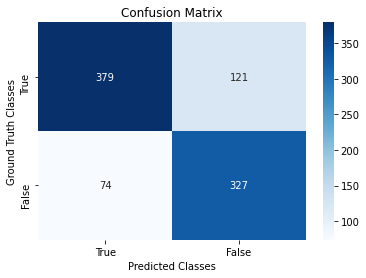

In [ ]:
# since we do not have the pl.Trainer that sets eval() for us, we have to do it manually
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/NLP/hw3/ckpt/' + wsd_params.model_name + '_suspended_' + wsd_params.pre_training + '.pth')['model'])
model.eval()
model.to(DEVICE)

predictions_wic = []
predictions_wsd = []

for i in range(0, len(dev_data), wsd_params.batch_size):
  batch = dev_data[i: i + wsd_params.batch_size]
  pred_wic, pred_wsd = model.predict(batch)

  predictions_wic += pred_wic
  predictions_wsd.extend([sent for pred in pred_wsd for sent in pred])

evaluate_wic(labels_wic, labels_wsd, predictions_wic, predictions_wsd)


### "Bridge" between WSD and WiC:
### Comparative analysis of the best of the two worlds

Let's now compare the best models derived from the two homeworks and see how they are related together. We will proceed computing the ROC curve and the AUC score of every approach (for the one belonging to Homework 1 we just take its numerical results).

AUC score for HW1_best-model: 0.677
AUC score for HW3_bert-base-finetuned: 0.776
AUC score for HW3_bert-base-freezed: 0.787


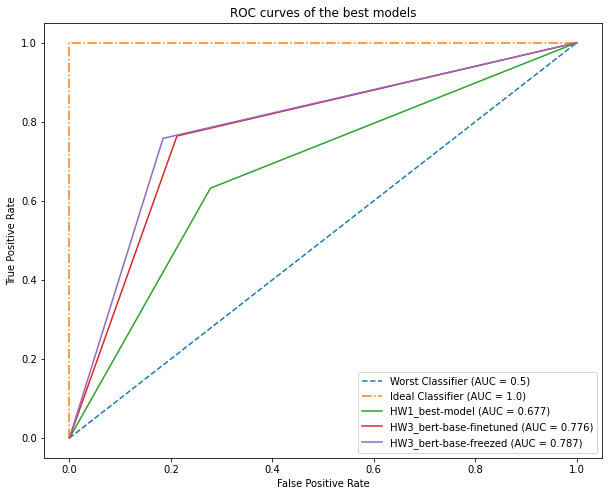

In [ ]:
y_gt = [1 if l_wic == 'True' else 0 for l_wic in labels_wic]
y_pred = [1 if p_wic == 'True' else 0 for p_wic in predictions_wic]

# ROC and AUC scores
# from HW1 we just take the numbers
fpr1 = np.array([0., 0.278, 1.])
tpr1 = np.array([0., 0.632, 1.])
auc1 = 0.677
print('AUC score for HW1_best-model: %.3f' % auc1)

# manually saved values for HW3 if needed
fpr2 = np.array([0., 0.21197007, 1.])
tpr2 = np.array([0., 0.764, 1.])
auc2 = 0.7760149625935162
print('AUC score for HW3_bert-base-finetuned: %.3f' % auc2)

# or compute directly on the labels and predictions
fpr3, tpr3, _ = roc_curve(y_gt, y_pred)
auc3 = roc_auc_score(y_gt, y_pred)
print('AUC score for HW3_bert-base-freezed: %.3f' % auc3)

fpr_max, tpr_max, _ = roc_curve(y_gt, y_gt)
fpr_min, tpr_min, _ = roc_curve(y_gt, [0 for _ in dev_data])

# finally, let's plot them wrt ideal and worst classifiers
plt.figure(figsize=(10, 8))
plt.plot(fpr_min, tpr_min, linestyle='--', label='Worst Classifier (AUC = 0.5)')
plt.plot(fpr_max, tpr_max, linestyle='-.', label='Ideal Classifier (AUC = 1.0)')
plt.plot(fpr1, tpr1, label='HW1_best-model (AUC = %.3f)' % auc1)
plt.plot(fpr2, tpr2, label='HW3_bert-base-finetuned (AUC = %.3f)' % auc2)
plt.plot(fpr3, tpr3, label='HW3_bert-base-freezed (AUC = %.3f)' % auc3)

plt.title('ROC curves of the best models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()

## Model Demo

This is just a nice demo that the user can play with to test the ability of the WSD system. 

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/NLP/hw3/ckpt/' + wsd_params.model_name + '_suspended_' + wsd_params.pre_training + '.pth')['model'])
model.eval()
model.to(DEVICE)


WSDModel(
  (bert): MyBERT(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30523, 768)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm((7

In [ ]:
#@title WSD demo { run: "auto" }

#@markdown Please, insert a sentence, an ambiguos word to be disambiguated and its pos tag:
sentence =  "Use the mouse to click on the button."#@param {type:"string"}
ambiguous_word =  "mouse"#@param {type:"string"}
pos_tag = "NOUN"#@param['NOUN', 'VERB', 'ADJ', 'ADV']

pos = WORDNET_POS[pos_tag]


In [ ]:
wsd_output = get_wsd_output(model, sentence, ambiguous_word, pos, None, verbose=True)
print('\nthe output of the WSD system is:\n', wsd_output)


Predictions:
  No.  Sense key        Definition                                                                                                                                                                                                        Score
-----  ---------------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -------
    1  mouse%1:06:00::  a hand-operated electronic device that controls the coordinates of a cursor on your computer screen as you move it around on a pad; on the bottom of the device is a ball that rolls on the surface of the pad  0.99944
    2  mouse%1:18:00::  person who is quiet or timid                                                                                                                                                                                    0.00025
    3  mouse%1:05:00::  an

Wow, even more than 99% of confidence on some simple sentences! We can say that the WSD system has learnt something even with the tremendous limitations that we have faced above.